In [1]:
from Annotation_helper import *

import os
import re  # For preprocessing
import time
from gensim.models import Word2Vec
from gensim.models import FastText
from gensim.utils import simple_preprocess
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

In [2]:
# roc curve and auc on an imbalanced dataset
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

In [3]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

In [4]:
data_folder = "../../Data"
structured_data_folder = data_folder + "/structured_data"
text_path = data_folder + "/text"
data_path = structured_data_folder + "/test.csv"
dist_folder = structured_data_folder + "/filtered_Distances"
figure_folder = "../Figures/Results/Embeddings"
model_folder = "../Models/Embeddings"

In [5]:
transactions = load_transactions(structured_data_folder + "\VOC Cochin Slave Transactions 1706-1801 - IISH - Database - 2018 - v1.csv")
permissions = load_permissions(structured_data_folder + "\VOC Cochin Slave Transport Permissions 1770-1795 - IISH - Database - 2018 - v1.csv")
matches = pd.read_csv(structured_data_folder + "/Matches/Bas3.csv", index_col=0)
possible_matches = pd.read_csv(structured_data_folder + "/blocked_possible_matches.csv", index_col=0)
possible_matches["total"] = possible_matches["transaction_indx"].astype(str) + "_" + possible_matches["permission_indx"].astype(str)
perms = permissions.iloc[:, 4:-1]
trans = transactions.iloc[:, 2:-1]

In [6]:
class text_loader:
    def __init__(self, file_names, max_files=None):
        self.file_names = file_names
        self.max_files = max_files
    
    def __iter__(self):
        self.file_n = 0
        self.row_n = 0
        self.lines = open(self.file_names[self.file_n], "r").read().split('\n')
        return self

    def __next__(self):
        if self.max_files:
            if self.file_n >= self.max_files:
                raise StopIteration
        if self.row_n >= len(self.lines):
            self.file_n += 1
            self.row_n = 0
            self.lines = open(self.file_names[self.file_n], "r").read().split('\n')
            clear_output(wait=True)
            print(f"[{self.file_n}/{self.max_files}]")
        if self.file_n <= len(self.file_names):
            if self.lines != "":
                self.row_n += 1
                res = simple_preprocess(str(self.lines[self.row_n - 1]))
                if len(res) > 4:
                    return res
                else:
                    return ['']
                    return next(self)
            else:
                self.row_n += 1
                return ['']
                return next(self)

def embed_dataframe(df, model):
    text = df.astype(str).agg(' '.join, axis=1)
    return pd.DataFrame(data = model.wv[text], index=df.index)
            
def evaluate_prediction(pred, y_true):
    cm = confusion_matrix(y_true, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    print("recall score: ", recall_score(y_true, pred))
    print("precision score: ", precision_score(y_true, pred))
    print("f1 score: ", f1_score(y_true, pred))

In [7]:
def load_or_train_fasttext(loc, force_new_model=False):
    try:
        if force_new_model:
            raise None
        model = FastText.load(loc)
        print("Loaded model")
    except:
        print("Generating model")
        allFiles = []
        for path, subdirs, files in os.walk(text_path):
            for name in files:
                allFiles.append(os.path.join(path, name))
        tl = text_loader(allFiles, max_files = 10000)
        t = iter(tl)
        model = FastText(sentences=t, size=200, window=5, min_count=1, workers=32)
        model.save(loc)
    return model

In [8]:
model = load_or_train_fasttext(model_folder + "/fasttext5.model", force_new_model=True)
print(len(model.wv.vocab))

[10000/10000]
134216


In [9]:
et = embed_dataframe(trans, model).astype('float16')
ep = embed_dataframe(perms, model).astype('float16')
et["indx"] = et.index
ep["indx"] = ep.index

In [10]:
et

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,indx
0,-0.066711,0.014610,0.023270,0.062805,-0.051483,-0.019165,-0.027725,-0.051666,-0.148560,0.027130,...,-0.085693,0.123230,-0.060059,-0.098633,-0.041473,-0.145508,-0.130615,0.117432,-0.070068,0
1,-0.059753,0.002300,0.037048,0.042572,-0.040131,-0.015556,-0.039520,-0.049377,-0.125732,0.030472,...,-0.061554,0.098145,-0.050232,-0.105164,-0.027206,-0.099915,-0.109375,0.094666,-0.049866,1
2,-0.135742,0.048279,0.105042,0.063232,-0.050079,0.029526,-0.013275,0.076172,-0.100647,0.060608,...,-0.046539,0.136353,-0.049622,-0.208740,-0.115601,0.010979,-0.184326,0.077942,-0.057007,2
3,-0.054993,0.008965,0.063232,0.027771,-0.037537,-0.022278,-0.052826,-0.047729,-0.131348,0.043640,...,-0.074707,0.099670,-0.018661,-0.114868,-0.060120,-0.118164,-0.123779,0.086975,-0.044342,3
4,-0.063049,-0.027054,0.073303,0.006535,-0.019302,-0.002647,0.007164,0.003399,-0.154785,0.019348,...,-0.185547,0.077637,-0.066956,-0.114990,-0.033905,-0.013412,-0.135742,0.014923,-0.094604,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7192,-0.058716,-0.059814,-0.020706,0.020004,-0.016953,0.002243,-0.007950,0.028656,-0.083008,0.093750,...,-0.003910,0.033020,-0.020218,-0.133301,0.036163,-0.070374,-0.107605,0.022751,-0.031891,7192
7193,-0.065186,-0.056519,-0.012024,-0.006260,-0.008324,-0.021515,-0.005829,-0.012215,-0.127563,0.100098,...,-0.066833,0.064819,-0.013077,-0.123352,0.031555,-0.074585,-0.115845,0.005417,-0.044617,7193
7194,-0.068237,-0.037323,-0.011406,0.010529,-0.022751,0.010872,-0.016495,-0.001419,-0.108215,0.089722,...,-0.044647,0.085144,-0.007145,-0.113281,0.023178,-0.096436,-0.115662,0.021713,-0.034729,7194
7195,-0.044952,-0.006523,-0.018127,0.004799,-0.026703,-0.006302,0.004650,-0.016937,-0.119507,0.072449,...,-0.118591,0.087891,-0.018570,-0.090393,-0.018784,-0.102478,-0.112061,0.046295,-0.047180,7195


In [11]:
allFiles = None
transactions = None
permissions = None
trans = None
perms = None
model = None

In [12]:
def generate_distances(data_path, force_new_dist=False):
    if force_new_dist:
        raise None
    distances = pd.read_csv(data_path, index_col=0)
    print("Loaded model")

In [13]:
def generate_distances(data_path, force_new_dist=False):
    try:
        if force_new_dist:
            raise None
        distances = pd.read_csv(data_path, index_col=0)
        print("Loaded model")
    except:
        print("Generating dataset")
        n_batches = 20
        et_indexes = np.linspace(0, et.shape[0], n_batches).astype(int)
        ep_indexes = np.linspace(0, ep.shape[0], n_batches).astype(int)

        batch_results = []
        for i in range(1, n_batches):
            clear_output(wait=True)
            print(f"[{i}/{n_batches}]")
            ep_slice = ep.iloc[ep_indexes[i-1]:ep_indexes[i] + 1]
            res = ep_slice.merge(et, how='cross',suffixes=('_permission', '_transaction'))
            comb_index = res['indx_transaction'].astype(str) + "_" + res['indx_permission'].astype(str)
            batch_results.append(res[comb_index.isin(possible_matches["total"])])

        distances = pd.concat(batch_results)
        batch_results = None
        distances.reset_index(inplace=True, drop=True)
        distances.to_csv(data_path)
    return distances

In [14]:
distances = generate_distances(data_path, force_new_dist=True)

[19/20]


In [15]:
Classifiers = dict()

In [16]:
X = distances[distances['indx_permission'].isin(matches["permission_indx"].unique())]
X["Match"] = 0
for i, match in matches.iterrows():
    if match["transaction_indx"] != "None":
        indx = distances.query(f"indx_permission == {match['permission_indx']} & indx_transaction == {match['transaction_indx']}").index
        X.loc[indx, "Match"] = 1
data = X.iloc[:, 3:-1]
y = X.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state=42)

<ipython-input-16-b5e4010a0070>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Match"] = 0
C:\Users\basvd\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [17]:
X_train = X_train.to_numpy().astype(float)
y_train = y_train.to_numpy().astype(float)

X_test = X_test.to_numpy().astype(float)
y_test = y_test.to_numpy().astype(float)

In [18]:
X_train.shape

(41176, 399)

In [19]:
est = make_pipeline(StandardScaler(), LogisticRegressionCV(scoring='f1'))
LGClf = fit_and_test_classifier(est, X_train, X_test, y_train, y_test, model_name="Log_reg2", figure_folder=figure_folder)

Classifiers["Logistic Regression"] = LGClf

C:\Users\basvd\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\basvd\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\basvd\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\basvd\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

KeyboardInterrupt: 

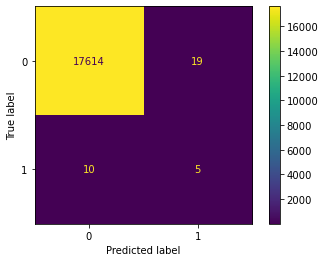

recall score:  0.3333333333333333
precision score:  0.20833333333333334
f1 score:  0.25641025641025644


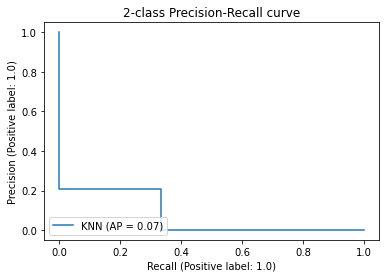

In [20]:
KNNClf = fit_and_test_classifier(KNeighborsClassifier(n_neighbors=1), X_train, X_test, y_train, y_test, model_name="KNN", figure_folder=figure_folder)

Classifiers["KNeigbors classifier"] = KNNClf

## 

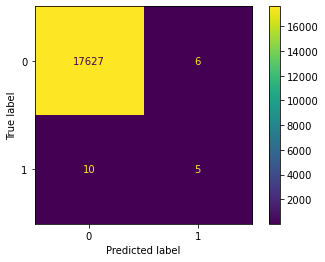

recall score:  0.3333333333333333
precision score:  0.45454545454545453
f1 score:  0.3846153846153846


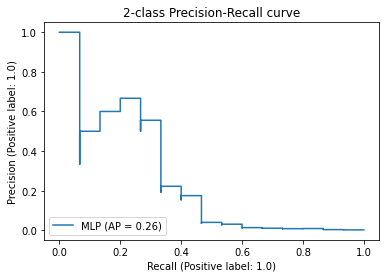

In [21]:
est = make_pipeline(StandardScaler(), MLPClassifier(activation='relu', solver='adam', alpha=1e-5, hidden_layer_sizes=(30, 30), learning_rate='adaptive', random_state=1, verbose=False))

NNClf = fit_and_test_classifier(est, X_train, X_test, y_train, y_test, model_name="MLP", figure_folder=figure_folder)
Classifiers["Neural network"] = NNClf

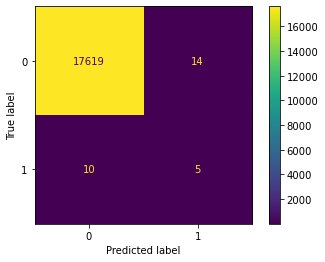

recall score:  0.3333333333333333
precision score:  0.2631578947368421
f1 score:  0.29411764705882354


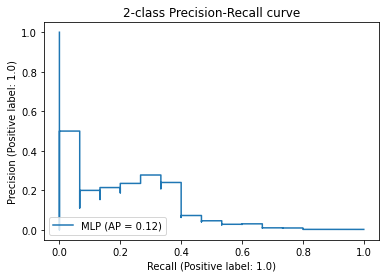

In [24]:
def make_layers(layer_size, n_layers):
    res = []
    for ls in layer_size:
        res += [ls for i in range(0, n_layers)]
    return res
        
layers = make_layers([50, 40, 20], 10)

est = make_pipeline(StandardScaler(), MLPClassifier(activation='relu', solver='adam', alpha=1e-5, hidden_layer_sizes=layers, learning_rate='adaptive', random_state=1, verbose=False))

NNClf = fit_and_test_classifier(est, X_train, X_test, y_train, y_test, model_name="MLP", figure_folder=figure_folder)
Classifiers["Neural network"] = NNClf

KNeigbors classifier: ROC AUC=0.666
Neural network: ROC AUC=0.927
No Skill: ROC AUC=0.500


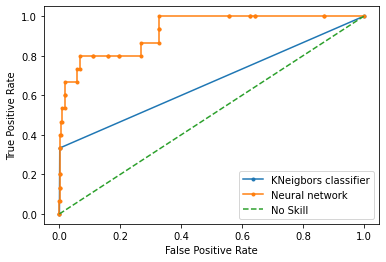

In [26]:
for name in Classifiers:
    model = Classifiers[name]
#     print("name:", name)
    # predict probabilities
    lr_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
#     print("lr_probs", lr_probs)
    if type(lr_probs[0]) == np.ndarray:
        lr_probs = lr_probs[:, 1]
    # calculate scores
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print(name + ': ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    plt.plot(lr_fpr, lr_tpr, marker='.', label=name)
    
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
print('No Skill: ROC AUC=%.3f' % (ns_auc))

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()